# Welcome to the pymakeplots quickstart guide

Greetings! pymakeplots is a python module for making publication quality plots and output datafiles (including moment zero, one, two, PVD's and spectra) from interferometric datacubes. It aims to estimate as many of the required parameters from the data as it can, to allow simple quick-looks at data, but with the ablity for the user to fine tune each assumption/parameter to produce publication quality products.

## Install

To start you will need to download the pymakeplots code and have it in your python path.

The simplest way to do this is to call `pip install pymakeplots`.

## Philosophy

This code makes moment maps/PVD's/spectra using the _masked_moment_ technique (see e.g. [Dame 2011](https://arxiv.org/abs/1101.1499v1)).

It creates an emission mask, using the following procedure:

* Make a copy of the observed datacube
* Smooth it with a boxcar in the spatial and spectral dimensions. In this implementation the spatial smoothing kernal has a width of 1.5x the beam, and the spectral kernal is 4x the channel width.
* Calculate the noise in the line-free channels of this new smoothed datacube. 
* Create a binary mask by clipping this smoothed datacube at 3x (or some other factor that the user can control with the `rmsfac` keyword) this noise level.
* This mask is then applied to the original, unsmoothed datacube when making moments/products. 

Note that formally this mask should be created on the datacube *before* primary beam correction, but then applied to the primary beam corrected cube. If you have all the products required then this code is set up to do this (see the section "Dealing with primary beam issues" below). 

## Getting started - a quick look at NGC5866

Now the code is installed, lets use it to take a quick look at some interferometric data. We will check out the CO(1-0) molecular gas distribution in NGC5866 (data originally from [Alatalo et al 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1796A/abstract)). The cube is handily hosted by NED so you should be able to reproduce the same plots on your system. 

OBSRA/OBSDEC keywords dont seem correct! Assuming galaxy centre is at pointing centre
Warning! Estimating galaxy distance using Hubble expansion. Set `gal_distance` if this is not appropriate.
No position angle given, estimating using the observed moment one.
Downsampling the observed moment one in PA estimate for speed. Set `useallpixels` to override.
PA estimate (degrees):  123.4


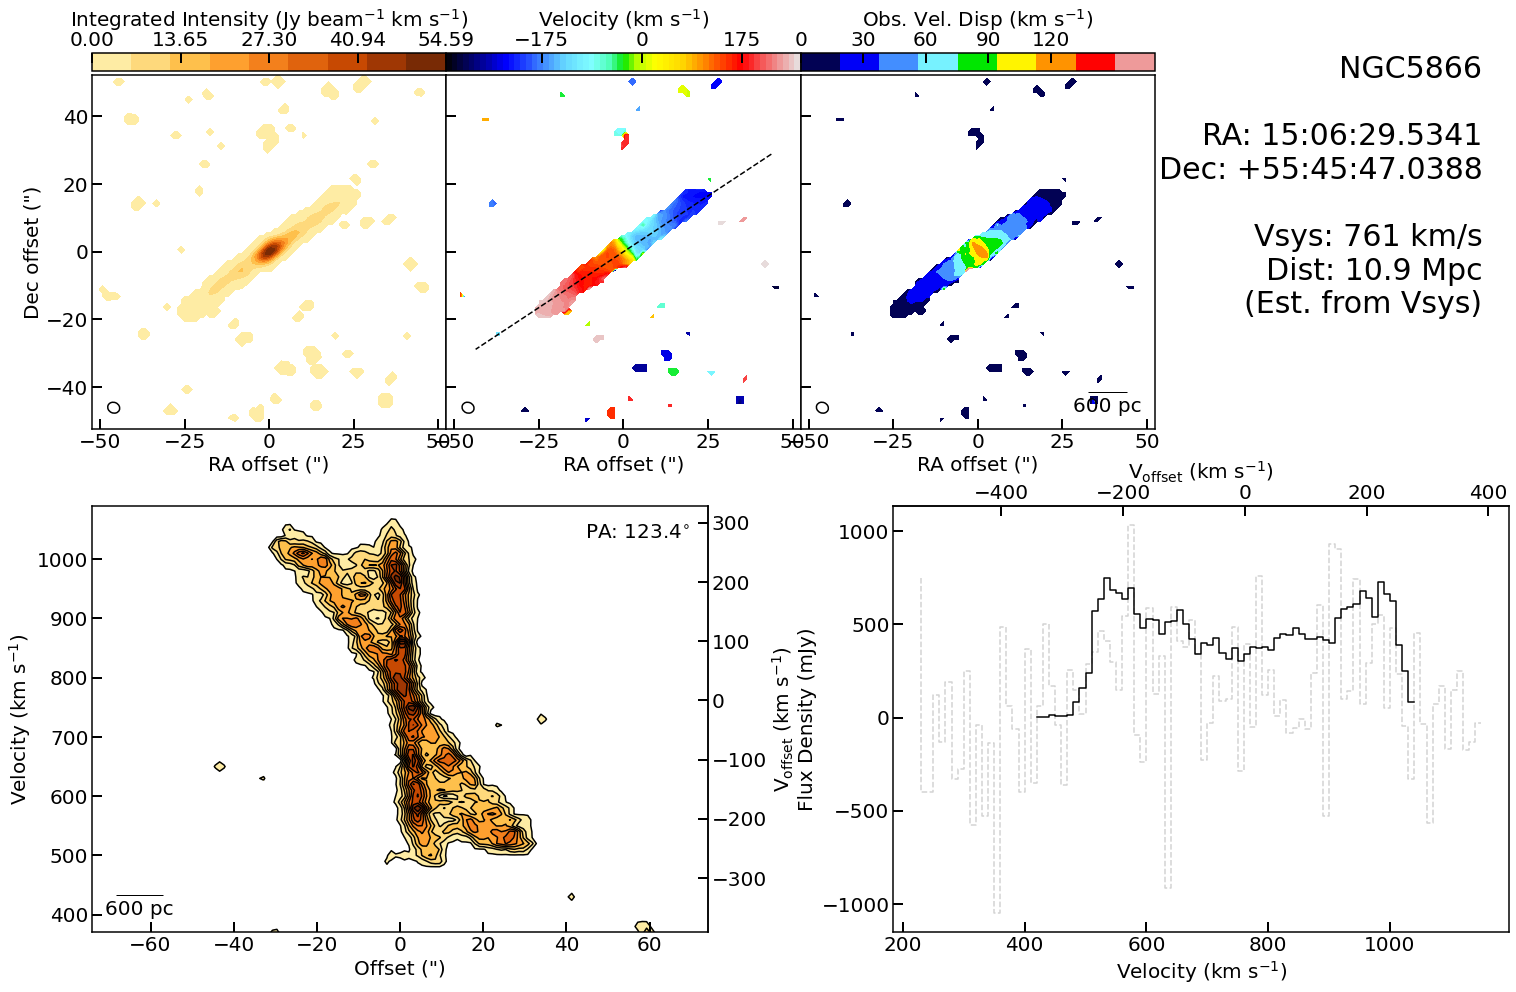

In [1]:
from pymakeplots import pymakeplots

file='http://ned.ipac.caltech.edu/img/2013MNRAS.432.1796A/NGC_5866:I:CO10:a2013.fits.gz'
# file hosted on the web in this case, but pointing the code to a cube on your local system will work.
plotter=pymakeplots(cube=file)
plotter.make_all()

You see a variety of warning/information messages, as the code tries its best to make clever guesses about the parameters needed to make a nice summary plot about this galaxy. (If you want to turn these off, you can set `plotter.silent=True`. 

All in all it does a pretty good job, as you see above. You can clearly see that this is an edge-on rotating disc, and the X-shape in the position-velocity diagram shows that this is likely a barred galaxy (such X-shapes are created when the rings at the bar corotation and inner-Lindblad resonance are seen edge-on). The plot is not perfect however, and some things can be improved!

## Taking control

First lets reinitialise everything:

In [15]:
plotter=pymakeplots(cube=file)

OBSRA/OBSDEC keywords dont seem correct! Assuming galaxy centre is at pointing centre


Now lets make improvements. First off you will have noticed an error message about the OBSRA/OBSDEC keywords. In this dataset they dont seem to have been set in the way expected. The guess for the centre the code has made is pretty good, but we can improve that, given that we know the real central position of the galaxy (from NED).

In [16]:
plotter.obj_ra, plotter.obj_dec = 226.6229117,  55.7632133

The code is estimating the distance to the galaxy using its estimate of the galaxies systemic velocity, and the Hubble constant. This isn't great for a galaxy this nearby, so we can instead set the distance with the `gal_distance` keyword:

In [17]:
plotter.gal_distance=14.9

Next, the code is trying to guess the optimum image size based on the extent of the detected emission, but given the S/N of this data its including too much noise. We can cut down the imaged field with the `imagesize` keyword.

In [18]:
plotter.imagesize=[35,25] # image ±35 arcseconds in the RA direction, and ±25 in the Dec direction

Next, inspect the integrated spectrum (bottom right panel of the plot above). The grey dashed lines are the integrated spectrum you get if you just collapse the datacube in the imaged area (this is very ratty in this case, because the imaged area is too large). The black spectrum is what you get when you just integrate within the emission mask. You can see in the  that the softwares guess for which channels contain real emission has cut a few channels of real signal away at the high velocity end (the black line profile doesnt drop to zero). We can change that by specifying by hand which channels to include: 

In [19]:
plotter.chans2do=[19,86]

Next, the automated estimation of the position angle is pretty good, but from previous estimates we actually know the value of this, which we can specify as below:

In [20]:
plotter.posang=125.

Now lets make the plot again!

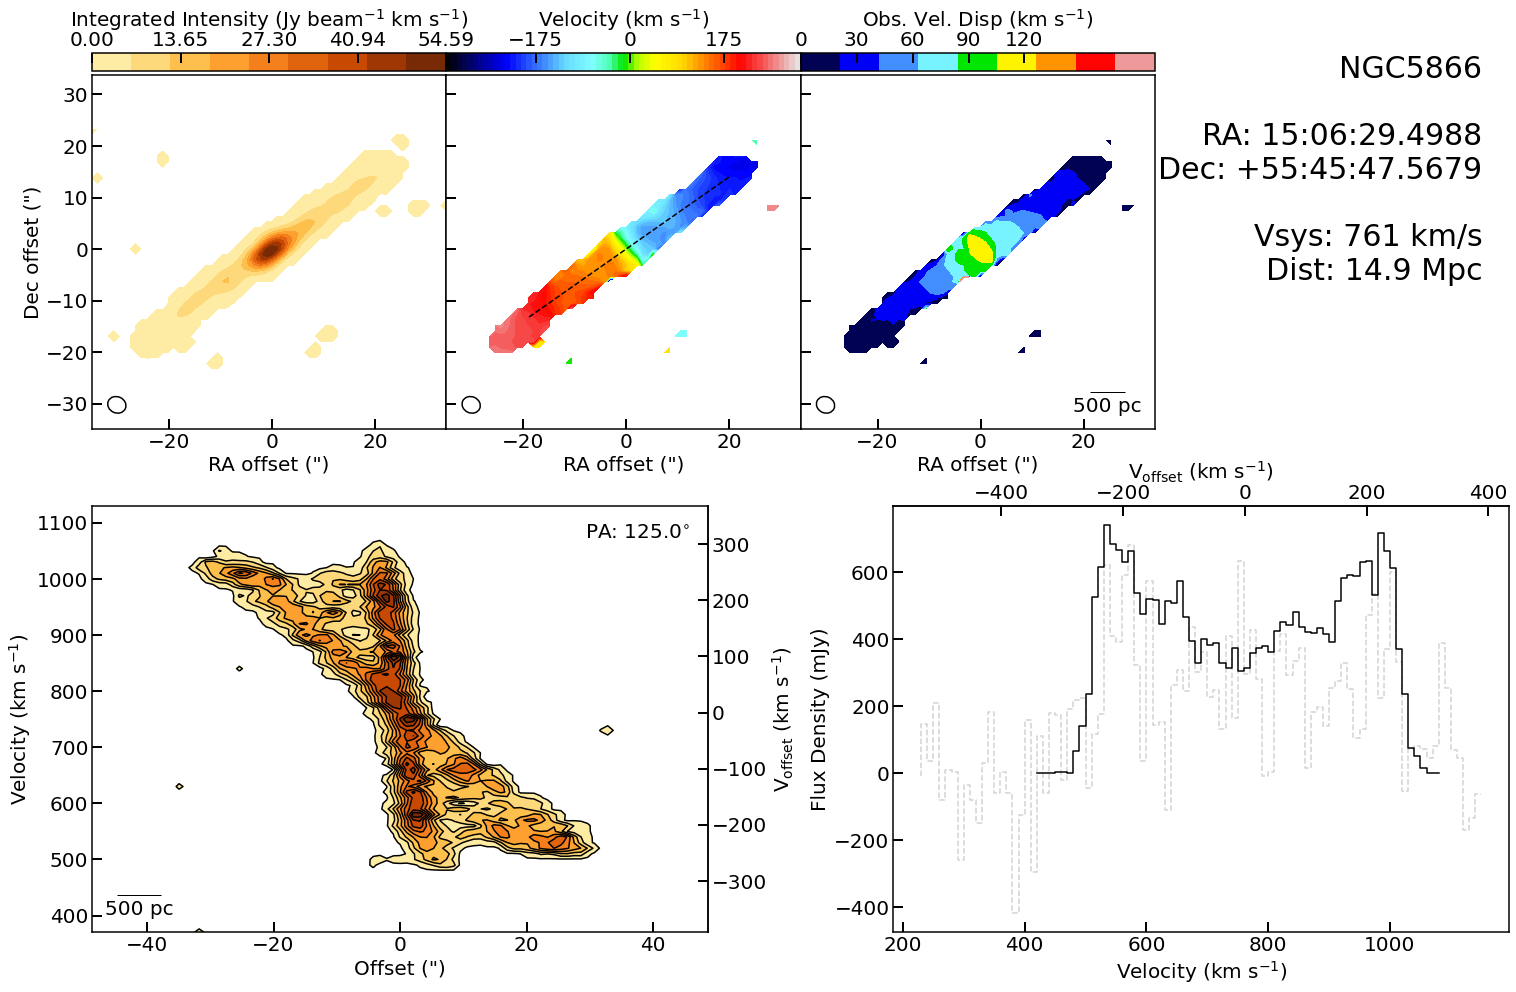

In [21]:
plotter.make_all()

Looks pretty good! We could save this plot as a PDF, and save the individual data products to disc by running `plotter.make_all(pdf=True,fits=True)`. No plot is produced on the screen if you choose to save to PDF. 

## Making individual plots/products

Perhaps the summary plot above was helpful for data inspection, but you now want to make individual plots of the products to put in your paper. You can do that as below:

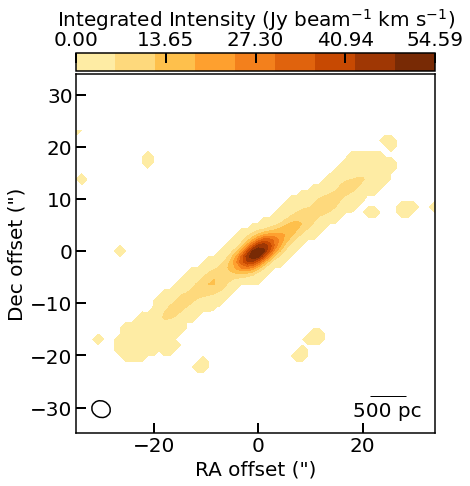

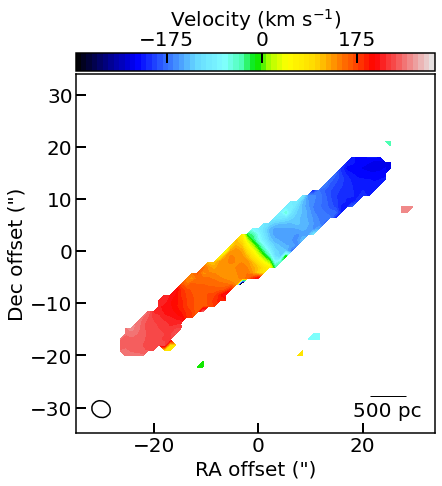

In [22]:
# Just moment zero
plotter.make_moments(mom=[0],pdf=False,fits=False)

# Just moment one
plotter.make_moments(mom=[1],pdf=False,fits=False)

The code will also let you plot any combination of the moment maps together in a single figure in any order (they will always be written to seperate fits files if `fits=True`).

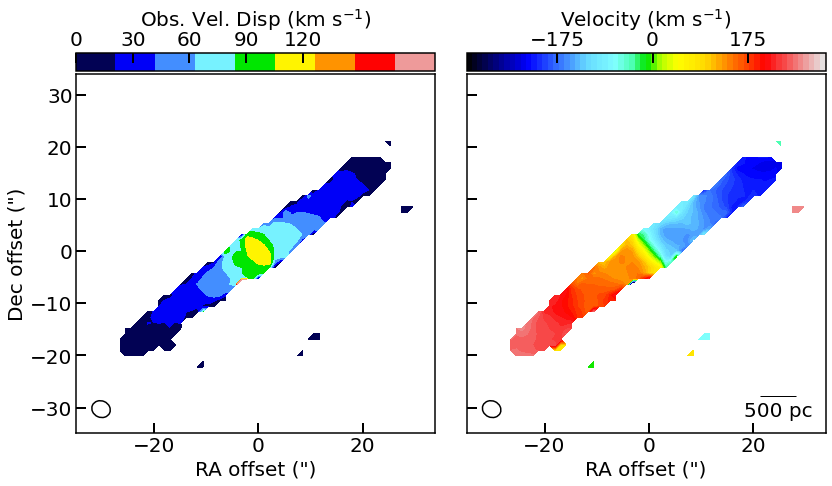

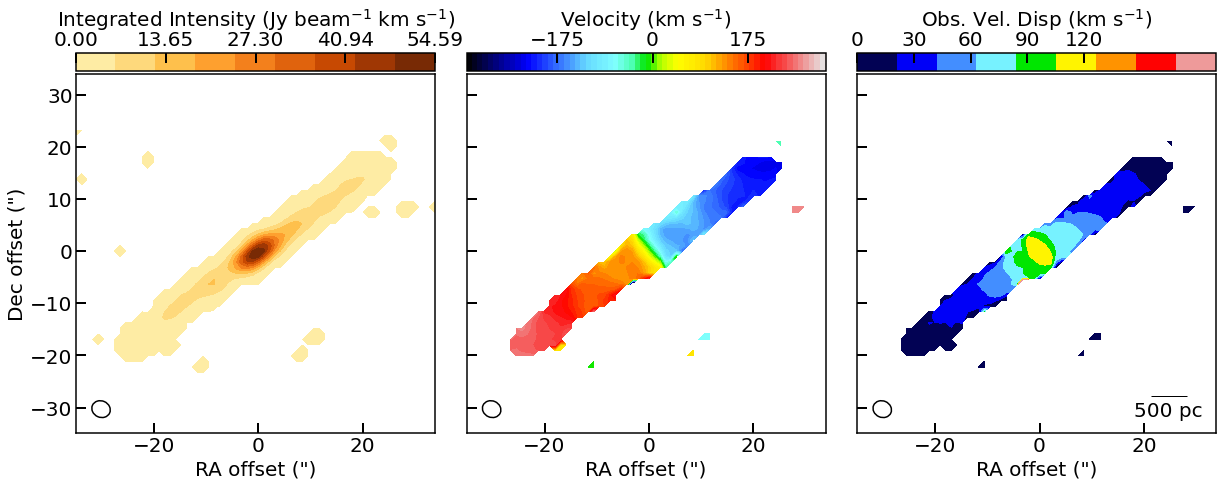

In [27]:
# Two of the moments together
plotter.make_moments(mom=[2,1],pdf=False,fits=False)

# Three of the moments together
plotter.make_moments(mom=[0,1,2],pdf=False,fits=False)

The PVD and spectrum can also be produced seperately:

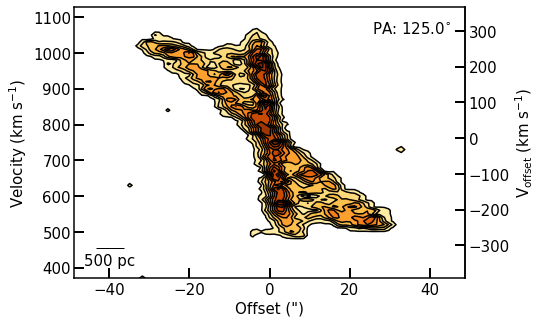

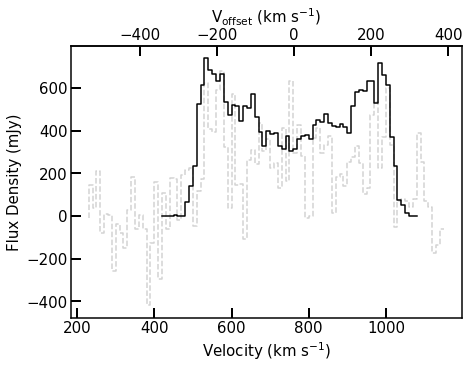

In [28]:
#make PVD
plotter.make_pvd(pdf=False,fits=False)

#make spec
plotter.make_spec(pdf=False,fits=False)

## Dealing with primary beam issues

In the example above we were working with a single datacube. However, as discussed above, formally to get the best possible products one should create the mask on datacubes produced without primary-beam correction (so the noise is spatially uniform) but apply them on primary-beam corrected datacubes (where the fluxes are formally correct). _pymakeplots_ is set up to handle this for the three cases below:

### 1) You have a primary beam corrected cube, and a matching cube of the primary beam response

In this case you would read in your data as below- then continue as above.

`plotter=pymakeplots(cube=path_to_pbcorred_cube,pb=path_to_pb_cube)`

### 2) You have a flat cube (not corrected for the primary beam), and a cube of the primary beam response

In this case you would read in your data as below, and the code would do primary beam correction for you.

`plotter=pymakeplots(cube_flat=path_to_flat_cube,pb=path_to_pb_cube)`

### 1) You have a primary beam corrected cube, and a flat cube (not corrected for the primary beam)

In this case you do not need the primary beam response file- and can read in the data as below:

`plotter=pymakeplots(cube=path_to_pbcorred_cube,cube_flat=path_to_flat_cube)`

If you were to supply all three inputs then the code would default to method one, above. 

## Other useful inputs

Here we list some other potentially useful inputs, that you may or may not need to use depending on the structure of your datafiles:

* `plotter.galname` -  set this to the name of your object. Useful if the header of your datacube does not contain this information, or you don't like the name used there!


* `plotter.vsys` - set this to the systemic velocity of your object. The code usually can estimate this well, but if it fails for any reason then you can set it directly. 


* `plotter.rmsfac` - set to clip your mask at a different multiple of the noise. Three sigma is the default, but depending on your source this may need to be adjusted up/down to get the best products.


* `plotter.maxvdisp` - set to the maximum observed velocity dispersion value to display in moment two plots. The moment two is the noisest to compute, and so often the range is thrown off by noise peaks. Set this to fix that issue!


* `plotter.make_square` - make the moment plots square (i.e. have equal x and y extents). Default = True. If your object is long/thin you may want to try setting this to False to avoid having significant whitespace in the plots.


* `plotter.useallpixels` - set to True to use all pixels to estimate the kinematic position angle, rather than a limited subset. Will give more accurate results, but at the expense of speed. 


* `plotter.ignore_firstlast_chans` set to ignore this number of channels at the beginning and end of the bandpass (in some cases end channels are especially noisy, and best ignored!)


* `plotter.linefree_chans_start` and `plotter.linefree_chans_end` - the code needs to know where to measure the noise (ideally in line-free channels!). Defaults = 1, 6.

## Issues?

If you have any issues feel free to get in touch, either by raising an issue on github, or via email. 